In [1]:
#import libraries 

import warnings
warnings.filterwarnings('ignore')
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tensorflow.keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

In [2]:
# clases and methods to be used during the code project

def readJSON(filename):
    with open(filename) as f:
        file = json.load(f)
    return file


def createDF():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })
    
    return df


def fromJSONToDF(json_file, df):
    
    for intent in json_file['intents']:
        
        for pattern in intent['patterns']:
            
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag
                
    return df

def computeMetrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

#PyTorch class used to represent a dataset. This custom data loader class is designed to handle tokenized data and corresponding labels, making it easy to feed data into a PyTorch model for training or inference.

class DataLoader(Dataset):
    
    def __init__(self, encodings, labels):
        
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
               
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)


In [3]:
import nltk
import re
import inflect
import string


from nltk.corpus import stopwords
from nltk.corpus import wordnet
from itertools import product
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

#download stop words
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('popular')

#create instance of lemma
lemmatizer = WordNetLemmatizer()

#create instance of spell correction 
spell = Speller(lang='en')

#initialize engine
inflect_engine = inflect.engine()


#list of possible contractions to fix any grammar and provide best answer
contractions_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

#create contraction list separate by pipe
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Add all punctuation characters
ignore_words=[]
ignore_words.extend(string.punctuation)
# Remove duplicates by converting to a set and back to a list
ignore_words = list(set(ignore_words))

#tokenize words
def tokenizeWrods(sentence):
     # tokenize the pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)

    return sentence_words

#correct spelling 
def correctSpelling(words_list):

    #correct each word, iterate and use the autocorrect to return appropiate word
    corrected_list = [spell(word) for word in words_list]

    return corrected_list


#correct contractions to original form ex I'm -> I am
def expandContractions(sentence, contractions_dict=contractions_dict):
    def replace(match):
        #find  if any contraction exist 
        return contractions_dict[match.group(0)]
    #remove replace contraction for original form
    return contractions_re.sub(replace, sentence)

#remove stop words 
def removeStopWords(words_list):
    #get the English stopwords
    stop_words = set(stopwords.words('english'))

    # Remove stopwords iterate if word is not in the stopword then I added to list
    corrected_list = [word for word in words_list if word not in stop_words]
    corrected_list = [word for word in words_list if word not in ignore_words]

    return corrected_list

#get word tags noun,verb,adverb, adjetive 
def getWordnetPos(word):
    
    #identify the tag that correspond
    tag = nltk.pos_tag([word])[0][1][0].upper()
   
    #create a tag dict
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    #return type of word noun,verb,adverb, adjetive 
    return tag_dict.get(tag, wordnet.NOUN)

def generateVariations(sentence_words):
    
    all_variations=[]
    for word in sentence_words:
        #lemma word by type 
        lemmatized_word = lemmatizer.lemmatize(word, getWordnetPos(word))
        #add to a variations, example if the sentences is I'm starving 
        #will be added [starve,starving]
        word_variations = set([word, lemmatized_word] )
        
        # Add singular and plural forms if the word is a noun, if is a noun
        #to increase our matching chances ex. people, person etc
#         if get_wordnet_pos(word) == wordnet.NOUN:
#             #add singular and plural of origninal word
#             word_variations.add(inflect_engine.singular_noun(word) or word)
#             word_variations.add(inflect_engine.plural_noun(word) or word)
#             #add s and p of lemma 
#             word_variations.add(inflect_engine.singular_noun(lemmatized_word) or lemmatized_word)
#             word_variations.add(inflect_engine.plural_noun(lemmatized_word) or lemmatized_word)
        
        #for initial stage we will add everything to the senctence
        #like it was part of it ex. [starve, starving]
        for variation in word_variations:
            all_variations.append(variation)

    #return all the sentence_word + variations 
    return all_variations


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/raemilcorniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/raemilcorniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/raemilcorniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/raemilcorniel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/raemilcorniel/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/raemilcorniel/nltk_data...
[nltk_data]    |   Package ga

In [4]:
#read file with patterns and responses 
filename = 'data.json'

intents = readJSON(filename)

In [5]:
#create a df that will be used for the EDA 
df = createDF()
df

,Pattern,Tag


In [6]:
#fill out the df with the JSON file
df = fromJSONToDF(intents, df)
df.head()

,Pattern,Tag
0,Hi there,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hey,greeting
4,Hola,greeting


In [7]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,Hi there,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hey,greeting
4,Hola,greeting


In [8]:
# EDA

In [9]:
#dimenssion of the dataset 
df.shape

(643, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 643 entries, 0 to 642
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  643 non-null    object
 1   Tag      643 non-null    object
dtypes: object(2)
memory usage: 15.1+ KB


In [11]:
print(f"Amount of classes or tags = {len(df['Tag'].unique())} ")
    


Amount of classes or tags = 183 


In [12]:
df.isnull().sum()
#show null values 
    


Pattern    0
Tag        0
dtype: int64

In [13]:
print(df['Pattern'].isnull().sum())

0


In [14]:
# visualizations 

In [15]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

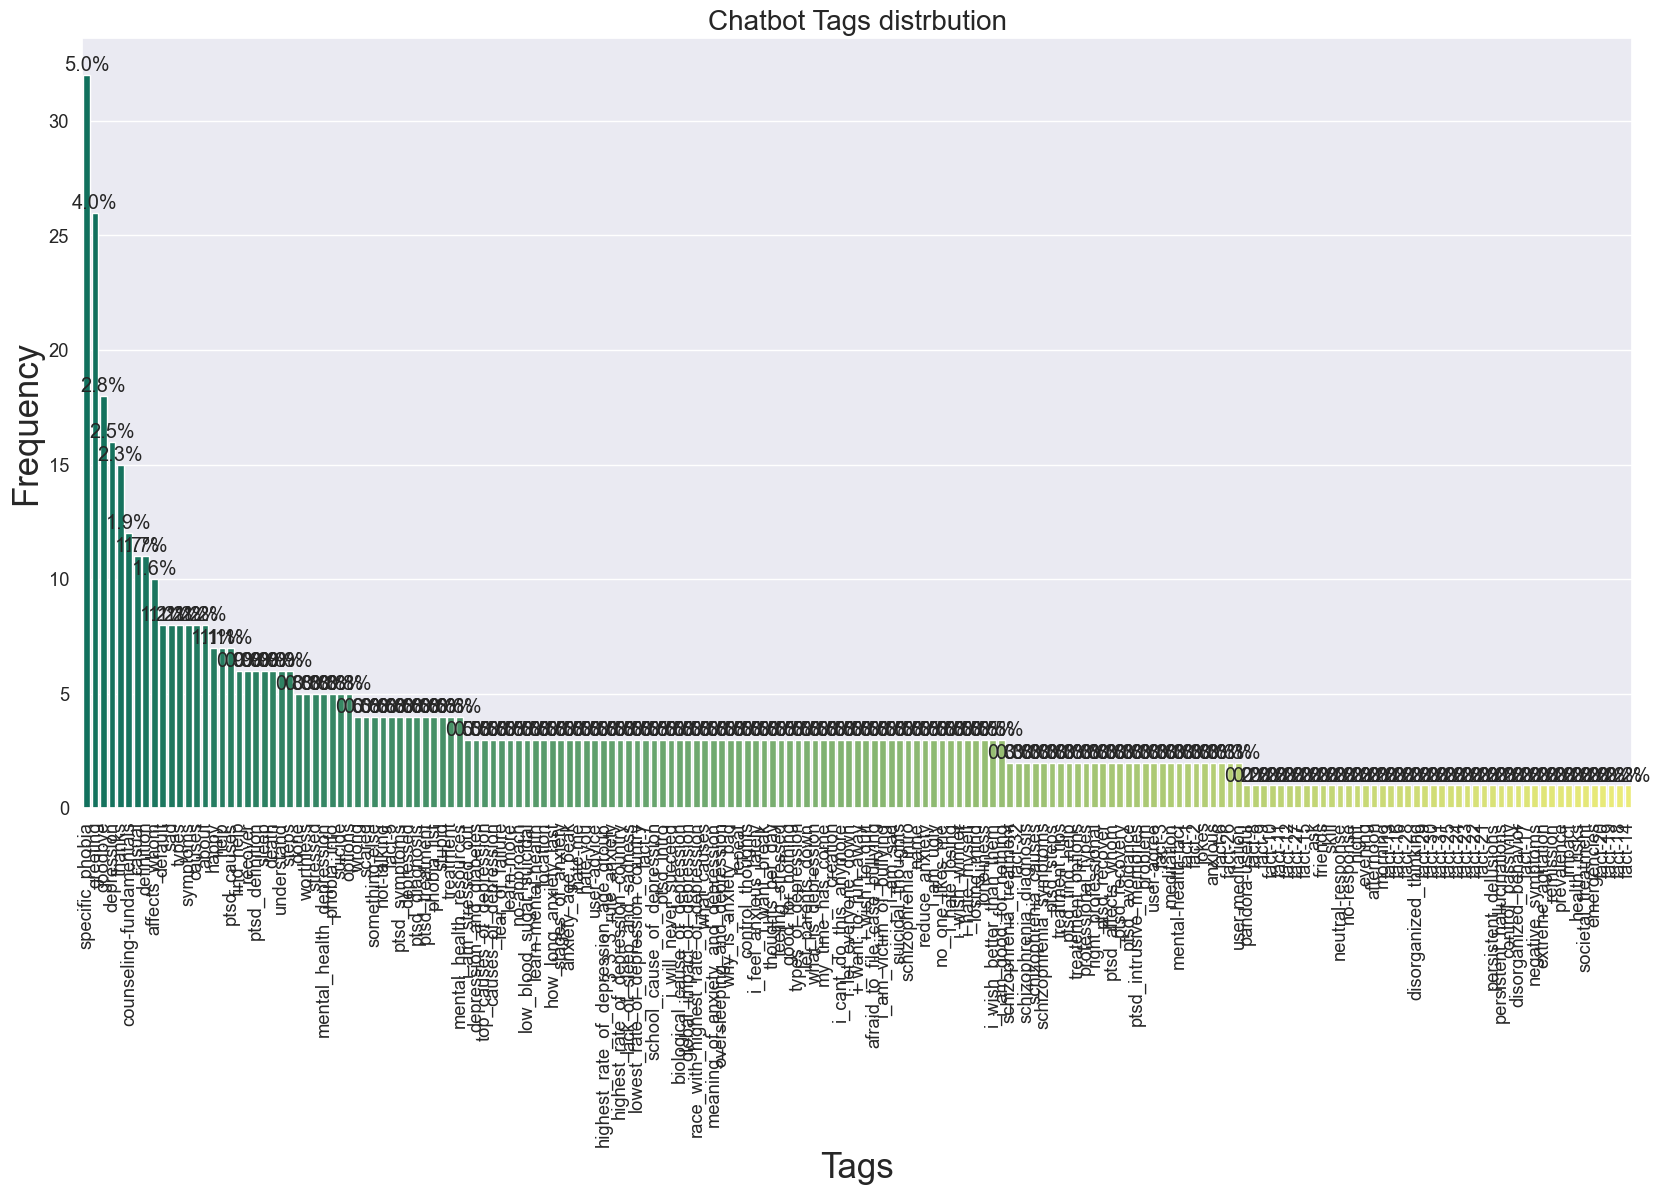

In [16]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")


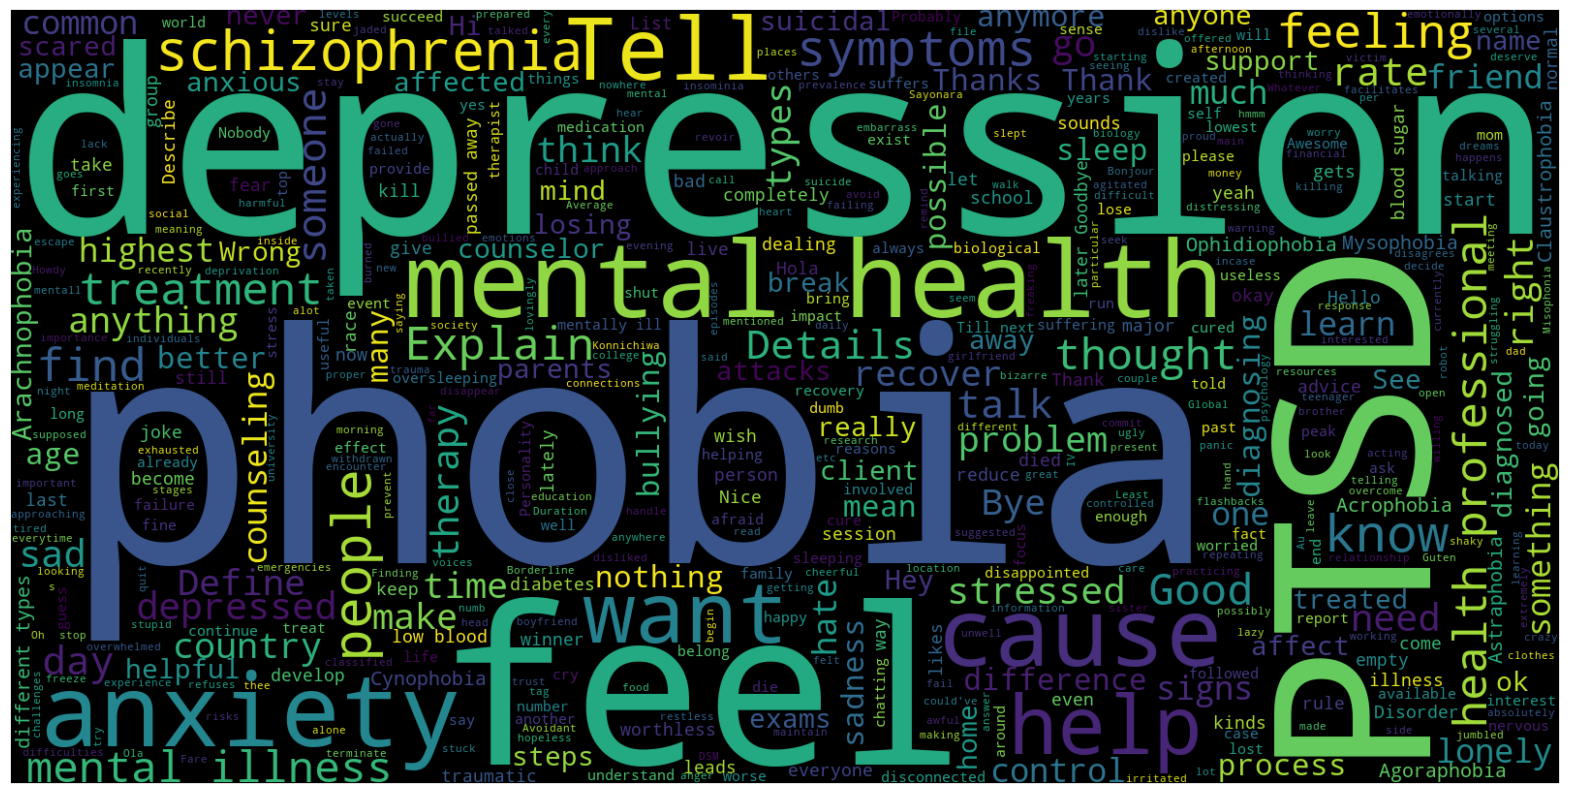

In [17]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

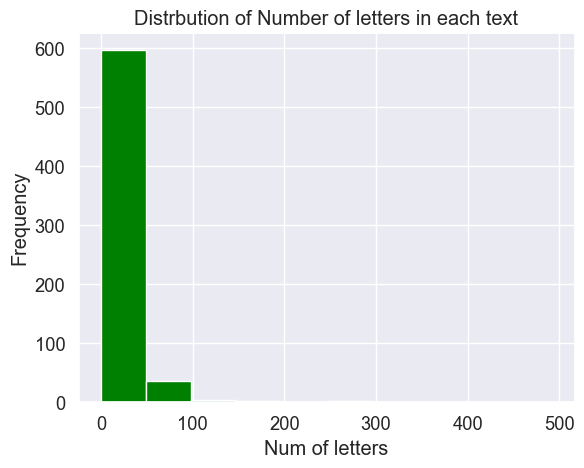

In [22]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='green')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

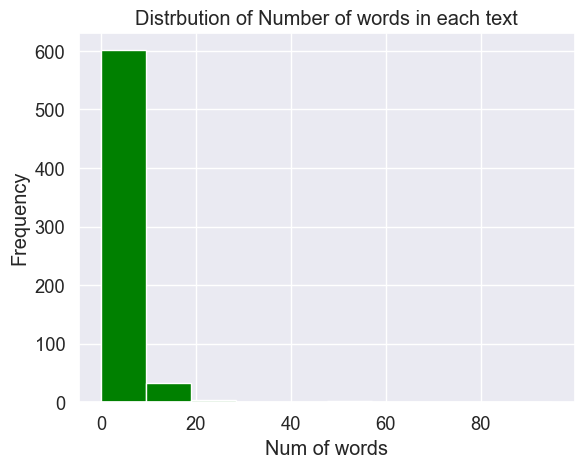

In [20]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

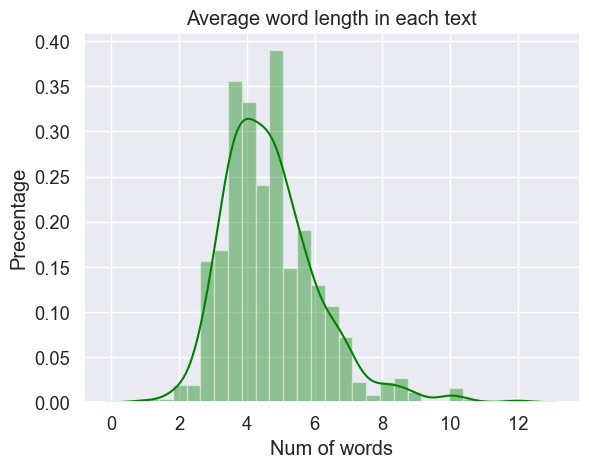

In [21]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='green')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

In [119]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

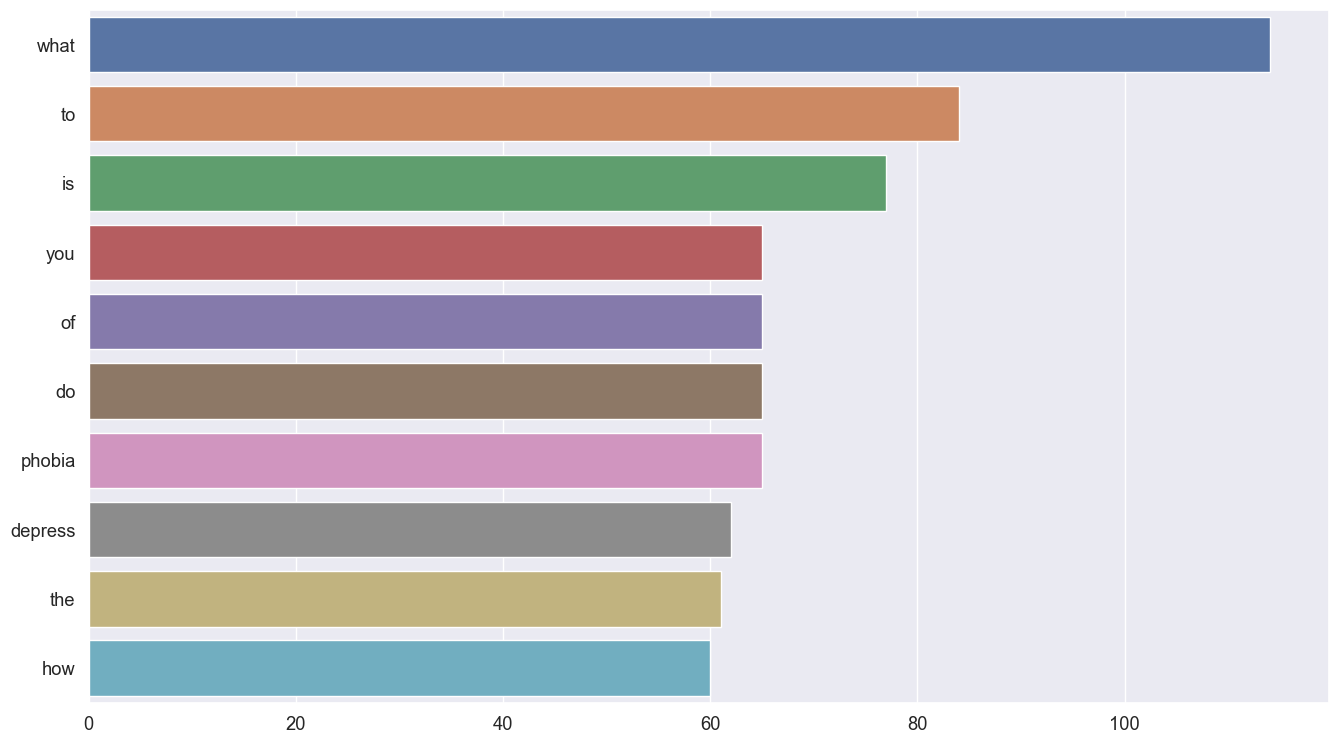

In [120]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

In [248]:
def getCorpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = getCorpus(df.Pattern)
corpus[:5]

['hi', 'there', 'how', 'are', 'be']

In [249]:
print(f"dataset contains {len(corpus)} words")

dataset contains 4128 words


In [250]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'i': 266,
 'be': 236,
 'what': 114,
 'do': 91,
 'is': 87,
 'to': 84,
 'can': 66,
 'you': 65,
 'of': 65,
 'a': 65}

In [ ]:
#preprocessing 

In [243]:
def processSentence(pattern):
     #lower case 
    pattern = pattern.lower()

    #remove contractions 
    pattern = expandContractions(pattern)

    #tokenize each word
    #w list of tokens
    w = nltk.word_tokenize(pattern)

    #correct any sentence spelling mistake
    w = correctSpelling(w)

    #remove stop words 
    w = removeStop_words(w)

    # lemmatize and add similar words
    w = generateVariations(w)

    return " ".join(w)  
    
       

In [244]:
#before preprocesing 
df.head(20)

,Pattern,Tag
0,Hi there,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hey,greeting
4,Hola,greeting
5,Hello,greeting
6,Good day,greeting
7,Bye,goodbye
8,See you later,goodbye
9,Goodbye,goodbye


In [259]:
#after preprocesing 
df['Pattern'] = df['Pattern'].apply(processSentence)

In [260]:
df.head(20)


,Pattern,Tag
0,hi there,greeting
1,how are be be you,greeting
2,is be be anyone there,greeting
3,hey,greeting
4,hold,greeting
5,hello,greeting
6,good day,greeting
7,bye,goodbye
8,see you later,goodbye
9,goodbye,goodbye


In [261]:
df2.head()

,Pattern,Tag
0,Hi there,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hey,greeting
4,Hola,greeting


In [ ]:
#modeling phase

In [262]:
#get tags 
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'thanks',
 'mental_health_depression',
 'mental_health_resources',
 'what_is_depression',
 'let_parents_down',
 'types_of_depression',
 'good_for_nothing',
 'feeling_stressed',
 'suicidal_thoughts',
 'fear_of_failure',
 'causes_of_depression',
 'top_causes_of_depression',
 'highest_rate_of_depression_age_group',
 'highest_rate_of_depression_country',
 'lowest_rate_of_depression_country',
 'school_cause_of_depression',
 'biological_cause_of_depression',
 'global_impact_of_depression',
 'race_with_highest_rate_of_depression',
 'meaning_of_anxiety_and_depression',
 'oversleeping_and_depression',
 'lack_of_sleep_and_sadness',
 'depression_and_diabetes',
 'low_blood_sugar_suicidal',
 'how_long_anxiety_last',
 'stages_of_anxiety',
 'anxiety_age_peak',
 'why_is_anxiety_bad',
 '3_3_3_rule_anxiety',
 'control_thoughts',
 'thoughts_per_day',
 'reduce_anxiety',
 'loneliness',
 'no_one_likes_me',
 'i_am_ugly',
 'i_am_good_for_nothing',
 'i_wish_better_than_them',
 'i_hate

In [263]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [264]:
len(labels)

183

In [265]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,Hi there,greeting,0
1,How are you,greeting,0
2,Is anyone there?,greeting,0
3,Hey,greeting,0
4,Hola,greeting,0


In [ ]:
#create train and test 

In [266]:
X = list(df2['Pattern'])
X[:5]

['Hi there', 'How are you', 'Is anyone there?', 'Hey', 'Hola']

In [267]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [129]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

In [189]:
# Masked language modeling (MLM): taking a sentence, the model randomly masks 15% of the words in the input then run the entire masked sentence through the model and has to predict the masked words. This is different from traditional recurrent neural networks (RNNs) that usually see the words one after the other, or from autoregressive models like GPT which internally masks the future tokens. It allows the model to learn a bidirectional representation of the sentence.
# Next sentence prediction (NSP): the models concatenates two masked sentences as inputs during pretraining. Sometimes they correspond to sentences that were next to each other in the original text, sometimes not. The model then has to predict if the two sentences were following each other or not.

model_name = "bert-large-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name, 
                                          max_length=max_len)

#bert-large-uncased - it has 30k words variation
#leng of labels or tag we have, labels in format label to id and id to label 
model = BertForSequenceClassification.from_pretrained(model_name, 
                                                      num_labels=num_labels, 
                                                      id2label=id2label, 
                                                      label2id = label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [131]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [132]:
full_data = tokenizer(X, truncation=True, padding=True)

In [134]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [135]:
fullDataLoader = DataLoader(full_data, y_test)

In [137]:
training_args = TrainingArguments(
    output_dir='./output', 
    do_train=True,
    do_eval=True,
    num_train_epochs=100,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=16,
    warmup_steps=100,                
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    load_best_model_at_end=True
)



In [138]:
trainer = Trainer(
    model=model,
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=test_dataloader,            
    compute_metrics= compute_metrics
)

In [139]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,5.212500,5.195173,0.024845,0.004352,0.002516,0.022013
100,4.767600,4.739672,0.118012,0.033590,0.033568,0.059755
150,3.869400,4.134569,0.223602,0.111959,0.110430,0.145981
200,2.949700,3.661399,0.360248,0.190736,0.184644,0.233099
250,2.353600,3.370077,0.366460,0.213846,0.220597,0.241071
300,1.868700,3.087167,0.434783,0.254145,0.251145,0.299292
350,1.383000,2.912395,0.472050,0.288232,0.279107,0.334425
400,1.080300,2.760031,0.496894,0.315675,0.318428,0.357832
450,0.837300,2.648725,0.521739,0.340238,0.335324,0.374707
500,0.687500,2.540542,0.540373,0.357642,0.358667,0.387048


TrainOutput(global_step=1600, training_loss=0.9036286136507988, metrics={'train_runtime': 1210.1819, 'train_samples_per_second': 39.829, 'train_steps_per_second': 1.322, 'total_flos': 2977163118576000.0, 'train_loss': 0.9036286136507988, 'epoch': 100.0})

In [145]:
#evaluation result 
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.101709,0.973029,0.946798,0.94874,0.953333
test,2.345373,0.571429,0.383003,0.38078,0.421083


In [170]:
#test of precition 

def predict(text):
    
     # Tokenize the input text and move to the appropriate device (MPS or CPU)
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to("mps")
    
#     # Move the model to the appropriate device
#     model.to(device)
    
#     # Set the model to evaluation mode
#     model.eval()
    
#     # Perform prediction
#     with torch.no_grad():
#         outputs = model(**inputs)

    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [171]:
text = "Hello"
predict(text)


SequenceClassifierOutput(loss=None, logits=tensor([[ 1.0698e+01,  2.8220e+00,  2.7367e+00,  1.2868e+00, -1.2075e+00,
         -1.1658e+00,  4.7167e-02, -1.3583e+00, -1.0590e+00,  3.8921e-01,
         -5.9763e-01,  3.1187e-02, -2.0503e+00,  8.2433e-01,  8.1825e-01,
         -1.6782e+00, -1.8172e+00, -2.1346e+00, -1.2542e+00,  1.0315e+00,
         -1.2478e+00, -7.7537e-01,  4.7613e-01, -5.3123e-01,  6.1541e-01,
          1.0442e+00,  1.8247e+00, -2.4353e+00,  1.0530e+00, -1.4176e+00,
         -1.5545e+00,  9.4095e-01,  1.0051e+00,  1.9144e+00,  3.6269e-02,
          2.4408e-01, -1.3241e+00, -3.1170e-01, -1.5043e-01,  9.4042e-01,
         -8.2573e-01,  1.6063e+00,  7.0838e-01,  9.2972e-01, -9.9887e-01,
         -1.1073e+00, -1.0140e+00,  2.2705e-01, -6.4032e-01, -3.2683e-01,
         -1.1274e+00, -1.8036e+00,  2.0501e-01, -2.0366e-01, -7.3709e-01,
         -6.5474e-01,  1.4733e+00, -6.1394e-01,  8.0726e-01, -3.6902e-01,
         -1.2991e+00,  4.2055e-01, -8.7816e-02,  2.1735e+00, -1.2088e

(tensor([[9.9305e-01, 3.7722e-04, 3.4639e-04, 8.1260e-05, 6.7083e-06, 6.9938e-06,
          2.3524e-05, 5.7694e-06, 7.7826e-06, 3.3117e-05, 1.2345e-05, 2.3151e-05,
          2.8880e-06, 5.1171e-05, 5.0861e-05, 4.1896e-06, 3.6459e-06, 2.6546e-06,
          6.4025e-06, 6.2948e-05, 6.4434e-06, 1.0334e-05, 3.6125e-05, 1.3192e-05,
          4.1523e-05, 6.3757e-05, 1.3915e-04, 1.9651e-06, 6.4318e-05, 5.4369e-06,
          4.7416e-06, 5.7500e-05, 6.1309e-05, 1.5221e-04, 2.3269e-05, 2.8643e-05,
          5.9697e-06, 1.6431e-05, 1.9306e-05, 5.7470e-05, 9.8268e-06, 1.1185e-04,
          4.5569e-05, 5.6858e-05, 8.2645e-06, 7.4150e-06, 8.1402e-06, 2.8160e-05,
          1.1829e-05, 1.6184e-05, 7.2680e-06, 3.6958e-06, 2.7546e-05, 1.8305e-05,
          1.0738e-05, 1.1659e-05, 9.7920e-05, 1.2145e-05, 5.0305e-05, 1.5515e-05,
          6.1211e-06, 3.4172e-05, 2.0553e-05, 1.9722e-04, 6.6994e-06, 3.0377e-04,
          9.9853e-06, 3.4841e-06, 9.5750e-07, 9.2457e-06, 1.3311e-04, 6.6568e-04,
          8.3504

In [156]:
model_path = "chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot/tokenizer_config.json',
 'chatbot/special_tokens_map.json',
 'chatbot/vocab.txt',
 'chatbot/added_tokens.json')

In [178]:
model_path = "chatbot"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)

#send pretrained and saved model and tokenization, device =cpu, since is mac and we dont have gpu 
chatbot= pipeline(task="text-classification", model=model, tokenizer=tokenizer, function_to_apply="softmax")



In [270]:
chatbot.model.save_pretrained(model_path)

In [179]:
chatbot("Hello")

[{'label': 'greeting', 'score': 0.9930504560470581}]

In [180]:
def chat(chatbot):
    
    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")
    
    text = input("User: ").strip().lower()
    
    while(text != 'quit'):

        score = chatbot(text)[0]['score']
        
        if score < 0.8:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue
        
        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])
        
        print(f"Chatbot: score {score}, label: {label}, response:  {response}\n\n")
            
        text = input("User: ").strip().lower()
        
        

In [160]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..
Type 'quit' to exit the chat


User:dd
Chatbot: score 0.9238449335098267, label: 71, response:  What do you think is causing this?


User:hello
Chatbot: score 0.9930504560470581, label: 0, response:  Hello, thanks for asking


User:i'm not feeling well
Chatbot: Sorry I can't answer that


User:i am not feeling well
Chatbot: Sorry I can't answer that


User:i am not fell good
Chatbot: Sorry I can't answer that


User:feel good
Chatbot: score 0.828901469707489, label: 70, response:  Why do you think you feel this way?


User:i am not feel good
Chatbot: Sorry I can't answer that


User:i am stress
Chatbot: score 0.8542506098747253, label: 44, response:  A break is putting your mind to rest and getting rid of negative thoughts and stress. Your life is completely in your hands and taking a few hours off from pressurizing your brain will definitely be beneficial for yo

In [165]:
pipe = pipeline("text-classification")
pipe(["This restaurant is awesome", "This restaurant is awful"])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[{'label': 'POSITIVE', 'score': 0.9998743534088135},
 {'label': 'NEGATIVE', 'score': 0.9996669292449951}]

In [188]:
from transformers import BertTokenizer

# Define the model name and maximum length
model_name = "bert-base-uncased"
max_len = 128

# Load the pre-trained tokenizer with the specified maximum length
tokenizer = BertTokenizer.from_pretrained(model_name, max_length=max_len)

# Example text to tokenize
text = "Here is an example sentence for tokenization.Here is an example sentence for tokenization.Here is an example sentence for tokenization."

# Tokenize the text
inputs = tokenizer(text, padding=True, truncation=True, max_length=max_len, return_tensors="pt")

# Print the tokenized inputs
print(inputs)


{'input_ids': tensor([[  101,  2182,  2003,  2019,  2742,  6251,  2005, 19204,  3989,  1012,
          2182,  2003,  2019,  2742,  6251,  2005, 19204,  3989,  1012,  2182,
          2003,  2019,  2742,  6251,  2005, 19204,  3989,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}


In [63]:
import torch

In [68]:
torch.device("mps")


device(type='mps')

In [73]:
!pip install xformers

  Using cached xformers-0.0.26.post1.tar.gz (4.1 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [245 lines of output]
      running bdist_wheel
      /Users/raemilcorniel/anaconda3/lib/python3.11/site-packages/torch/utils/cpp_extension.py:499: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
        warnings.warn(msg.format('we could not find ninja.'))
      running build
      running build_py
      creating build
      creating build/lib.macosx-11.1-arm64-cpython-311
      creating build/lib.macosx-11.1-arm64-cpython-311/xformers
      copying xformers/_deprecation_warning.py -> build/lib.macosx-11.1-arm64-cpython-311/xformers
      copying xformers/attn_bias_utils.py -> build/lib.macosx-11.1-arm64-cpython-311/xformers
      copying xformers/checkpoint.py -> build/lib.ma

Failed to build xformers
ERROR: Could not build wheels for xformers, which is required to install pyproject.toml-based projects


In [3]:
pip install missingno
pip install keras

Note: you may need to restart the kernel to use updated packages.
